In [1]:
import torch
import torch.nn as nn
import cv2
import os
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import torch.optim
import torch.utils.data
from PIL import Image
import utils
# import scienceplots
# plt.style.use(['science','grid'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/fawazsammani/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load CLIP, train and val transforms
images_path = '/images/val/'
model_name = "ViT-B/16"
classifier_folder = "vitb16"
dst_name = "imagenet"
classifier_base_folder = 'classifiers_' + dst_name + '/'
img_size = 224

clip_tower, clip_model, clip_args = utils.get_clip_model(model_name, device, img_size)

for p in clip_model.parameters():
    p.requires_grad = False

extractor = utils.Extractor(clip_model, device)
transform_val_image = utils.get_val_transform(img_size)

In [3]:
# load descriptors and class names
all_descriptors = json.load(open("classifiers/" + classifier_base_folder + classifier_folder + "/all_descriptors_no_class.json", 'r'))
imagenet_classes = json.load(open("classifiers/"+ classifier_base_folder + classifier_folder + "/" + dst_name + "_classes.json", 'r'))

# build a mapping from imagenet class folder name to class id (used later)
imagenet_class_index_file = json.load(open('classifiers/imagenet_class_index.json', 'r'))
folder2id = {v[0]:int(k) for k,v in imagenet_class_index_file.items()}

# load descriptor classifier and concept classifier
ckpts = torch.load('classifiers/' + classifier_base_folder + classifier_folder +  '/clip_zeroshot_concept_cls_no_class.pth', map_location=torch.device('cpu'))
dim = ckpts['layer']['weight'].shape[-1]

concept_classifier = nn.Linear(dim, len(all_descriptors), bias = False)
concept_classifier.load_state_dict(ckpts['layer'])

image_classifier = nn.Linear(dim, len(imagenet_classes), bias = False)
ckpts = torch.load('classifiers/' + classifier_base_folder + classifier_folder +  '/clip_zeroshot_cls.pth', map_location=torch.device('cpu'))
image_classifier.load_state_dict(ckpts['layer'])

concept_classifier = concept_classifier.to(device)
image_classifier = image_classifier.to(device)

# precompute once all textual concepts for each class
with torch.no_grad():
    weight_dissection = image_classifier.weight.data @ concept_classifier.weight.data.T

In [4]:
cls_folder = 'n02089078'  # will choose randomly if None # 

if cls_folder is None:
    cls_images = utils.get_random_cls_images(images_path)
    cls_folder = cls_images[0].split('/')[-2]
else:
    cls_images = os.listdir(images_path + cls_folder)
    cls_images = [images_path + cls_folder + '/' + iname for iname in cls_images]

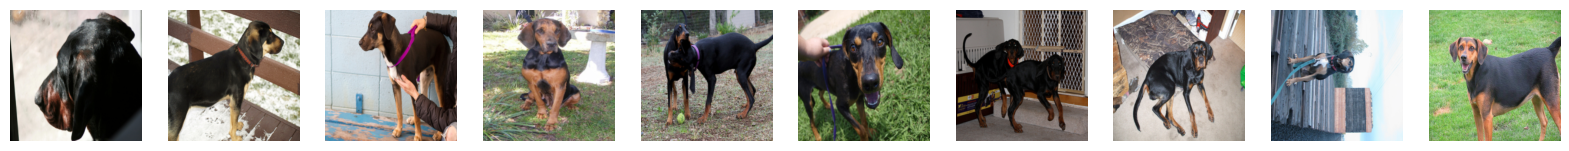

In [5]:
test_images = [Image.open(p).convert('RGB') for p in cls_images]
test_images = [transform_val_image(img) for img in test_images]
test_images = torch.stack(test_images, dim = 0).to(device)

fig, axs = plt.subplots(1, 10, figsize=(20,10))
np.vectorize(lambda ax:ax.axis('off'))(axs)
for i in range(10):
    axs[i].imshow(utils.show_image(test_images[i]))

In [6]:
patch_h, patch_w = clip_args[1], clip_args[1]  # num_patches at the height (not patch height or patch_size)
K = 3
threshold_by_negative = True
foreground_method = 'svd'
num_patches = patch_h * patch_w
feat_type = 'last_layer'   

In [7]:
with torch.no_grad():
    test_fts = extractor.extract(feat_type = feat_type, input_imgs = test_images)
    extractor.clear()

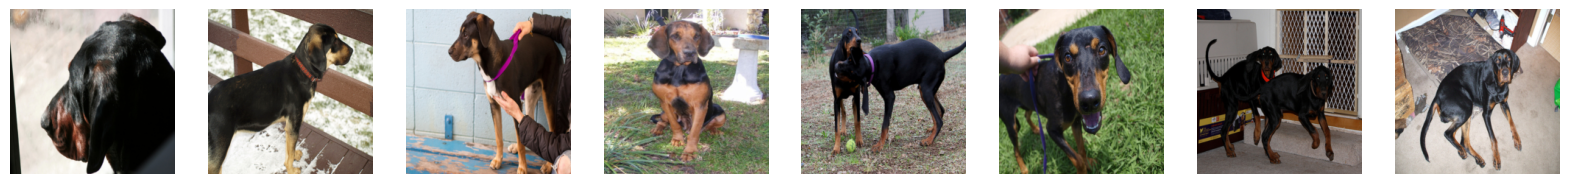

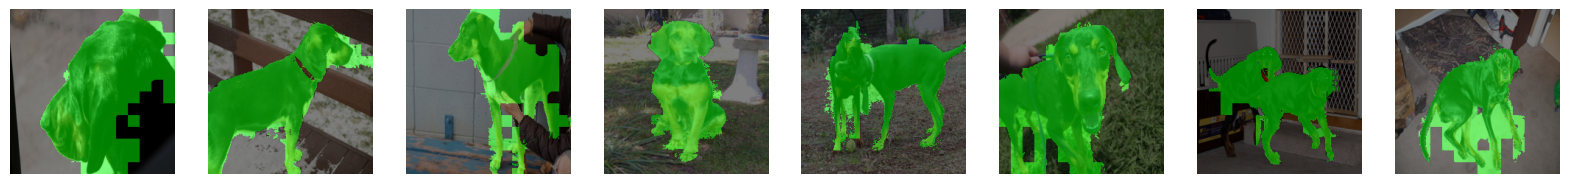

In [8]:
all_flat_features = extractor.flatten_feats(test_fts[:, 1:]).cpu().numpy()
all_flat_features_pt = torch.from_numpy(all_flat_features)

pca_features, foreground_component = utils.get_pca_features(K, foreground_method, all_flat_features, all_flat_features_pt,
                                                            threshold_by_negative)

number_of_images = test_images.shape[0]
all_fg_indices, _ = utils.get_foreground_background_indices(pca_features, num_patches, number_of_images,
                                                            initial_threshold = 0 if threshold_by_negative else 0.4,
                                                            foreground_component = foreground_component,
                                                            patch_h = patch_h, patch_w = patch_w)

upscaled_masks = utils.upscale_foreground_masks(all_fg_indices, img_size)

# takes a while for all cls images
overlaid_results, crf_masks = [], []

for i in range(len(all_fg_indices)):
    overlaid_result, crf_mask = utils.get_foreground_crf_map(upscaled_mask = upscaled_masks[i], image = test_images[i],
                                                             img_size = img_size, DEFAULT_CRF_PARAMS = (10, 40, 13, 3, 3, 5.0))

    overlaid_results.append(overlaid_result)
    crf_masks.append(crf_mask)

crf_masks = np.stack(crf_masks).astype(np.uint8)

fig, axs = plt.subplots(1, 8, figsize=(20,10))
np.vectorize(lambda ax:ax.axis('off'))(axs)
for i in range(8):
    axs[i].imshow(utils.show_image(test_images[i]))

fig, axs = plt.subplots(1, 8, figsize=(20,10))
np.vectorize(lambda ax:ax.axis('off'))(axs)
for i in range(8):
    axs[i].imshow(overlaid_results[i])

In [9]:
# part segmentation
K_parts = 5
all_fg_indices_flat = np.stack(all_fg_indices).reshape(-1)
# pca
pca_features_rem = utils.get_component_feats(all_flat_features[all_fg_indices_flat], K_parts)
pca_colored_segments, pca_colored_segments_viz = utils.get_pca_part_segments(K_parts, pca_features_rem, all_fg_indices, crf_masks, test_images)
# k-means
kmeans_segments = utils.kmeans_clustering(K_parts, all_flat_features_pt[all_fg_indices_flat], all_fg_indices_flat, device)
kmeans_colored_segments, kmeans_colored_segments_viz = utils.get_kmeans_part_segments(kmeans_segments, all_fg_indices, crf_masks, test_images)

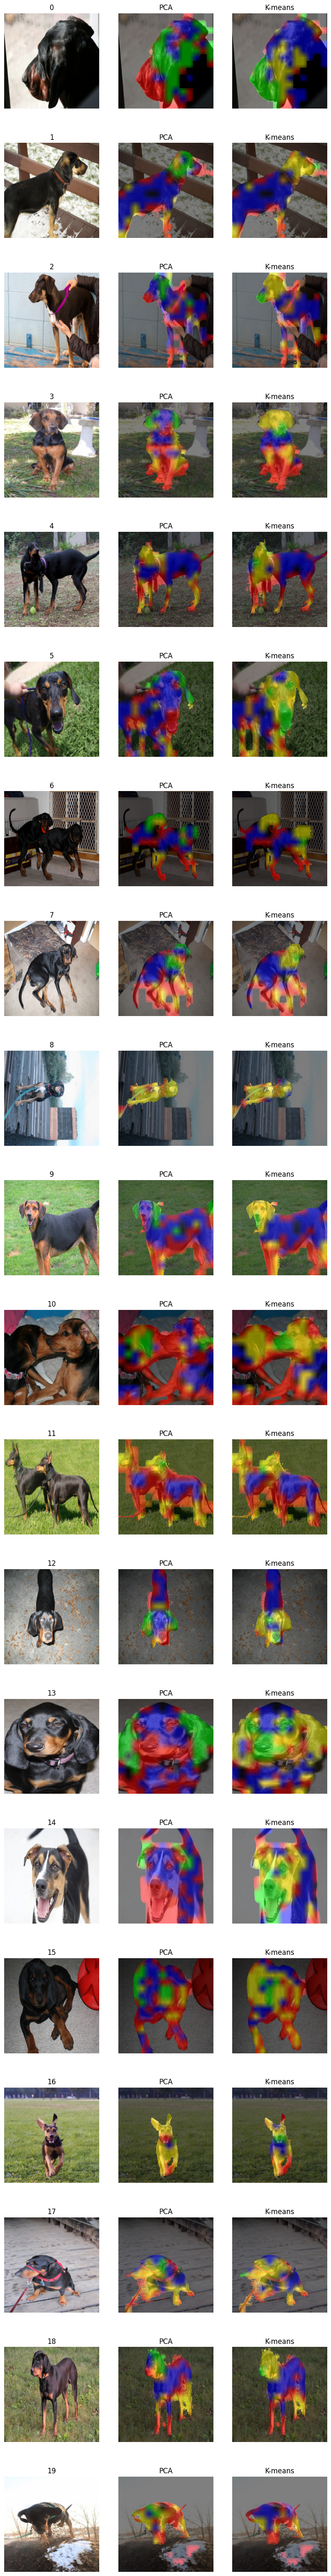

In [10]:
# k-mean results are not identical across runs, as K-means involves randomness (in initializing clusters)

images_to_show = 20
fig, axs = plt.subplots(images_to_show, 3, figsize=(10,80))
np.vectorize(lambda ax:ax.axis('off'))(axs)
for i in range(images_to_show):
    axs[i, 0].imshow(utils.show_image(test_images[i]))
    axs[i, 0].set_title(str(i))
    axs[i, 1].imshow(utils.overlay_segments_on_image(test_images[i], pca_colored_segments_viz[i]))
    axs[i, 1].set_title('PCA')
    axs[i, 2].imshow(utils.overlay_segments_on_image(test_images[i], kmeans_colored_segments_viz[i]))
    axs[i, 2].set_title('K-means')

In [13]:
# hyperparameters below need to be set correctly 

index = 3

mean_offset = 0.02
op_initial_topk = 500
topk = 3
use_ot = True
threshold_by_relevance = True
circle_thickness = 1

# pca results
pca_cs_result = pca_colored_segments[index]
pca_cs_result_viz = pca_colored_segments_viz[index]
pca_outs = utils.draw_circle_on_components_with_augments(test_images[index], pca_cs_result, circle_thickness = circle_thickness)

textual_concepts_pca = utils.get_corresponding_textual_concepts(img = test_images[index],
                                                                cirlce_images = pca_outs[:3],
                                                                transform = transform_val_image,
                                                                clip_tower = clip_tower,
                                                                concept_classifier = concept_classifier,
                                                                all_descriptors = all_descriptors, device = device,
                                                                threshold_by_relevance = threshold_by_relevance,
                                                                topk = topk, use_ot = use_ot, lambda_sinkhorn = 1,
                                                                mean_offset = mean_offset,
                                                                op_initial_topk = op_initial_topk)

pred_filtered_pca, scores_filtered_pca, _ = utils.get_relevance_score(textual_concepts_pca, test_images[index], clip_tower, device)

# kmeans
kmeans_cs_result = kmeans_colored_segments[index]
kmeans_cs_result_viz = kmeans_colored_segments_viz[index]
kmeans_outs = utils.draw_circle_on_components_with_augments(test_images[index], kmeans_cs_result, circle_thickness = circle_thickness)
textual_concepts_k = utils.get_corresponding_textual_concepts(img = test_images[index],
                                                             cirlce_images = kmeans_outs[:3],
                                                             transform = transform_val_image,
                                                             clip_tower = clip_tower,
                                                             concept_classifier = concept_classifier,
                                                             all_descriptors = all_descriptors, device = device,
                                                             threshold_by_relevance = threshold_by_relevance,
                                                             topk = topk, use_ot = use_ot, lambda_sinkhorn = 1,
                                                             mean_offset = mean_offset,
                                                             op_initial_topk = op_initial_topk)

pred_filtered_k, scores_filtered_k, _ = utils.get_relevance_score(textual_concepts_k, test_images[index], clip_tower, device)

In [15]:
# MI Plot
deletion_scores_pca = utils.single_example_scores(class_folder = cls_folder,
                                                  concepts_with_scores = (pred_filtered_pca, scores_filtered_pca),
                                                  weight_dissection = weight_dissection,
                                                  folder2id = folder2id, topk_w = 50,
                                                  all_descriptors = all_descriptors)

deletion_scores_k = utils.single_example_scores(class_folder = cls_folder,
                                                concepts_with_scores = (pred_filtered_k, scores_filtered_k),
                                                weight_dissection = weight_dissection,
                                                folder2id = folder2id, topk_w = 50,
                                                all_descriptors = all_descriptors)

/Users/fawazsammani/Desktop/clip-interpret/utils.py:641: RuntimeWarning: invalid value encountered in divide
  contingency_table /= np.sum(contingency_table)


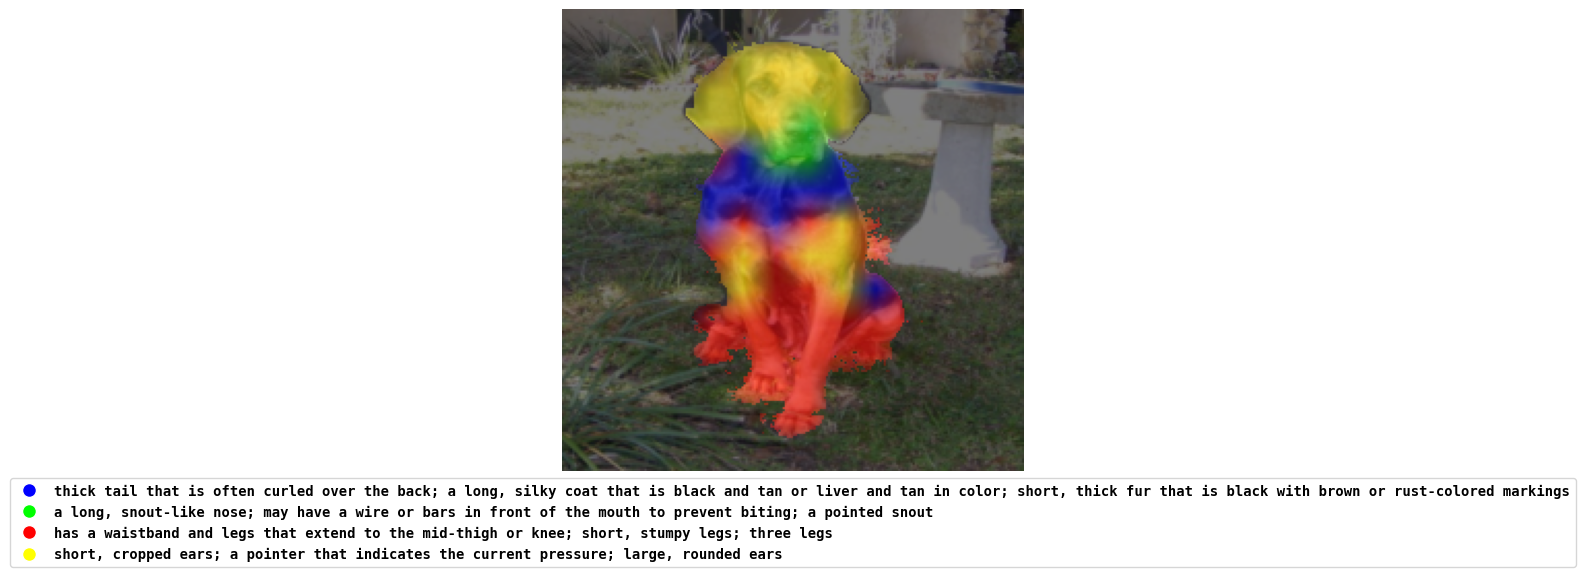

In [14]:
# multi-modal explanation plot
show_pca = False

if show_pca:
    cs_result_viz = pca_cs_result_viz
    unique_colors = pca_outs[-1]
    pred_filtered = pred_filtered_pca.copy()
    scores_filtered = scores_filtered_pca.copy()
    textual_concepts = textual_concepts_pca.copy()
else:
    cs_result_viz = kmeans_cs_result_viz
    unique_colors = kmeans_outs[-1]
    pred_filtered = pred_filtered_k.copy()
    scores_filtered = scores_filtered_k.copy()
    textual_concepts = textual_concepts_k.copy()

plt.figure(figsize=(8, 6))
plt.imshow(utils.overlay_segments_on_image(test_images[index], cs_result_viz))
plt.axis('off')


legend_handles = []
for color, text_row in zip(unique_colors[1:], textual_concepts):
    color_hex = '#{:02x}{:02x}{:02x}'.format(*color)
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_hex,
                                     label='; '.join(text_row)))

plt.legend(handles=legend_handles, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 0),
           prop={'family': 'monospace', 'weight': 'bold'})

plt.show()

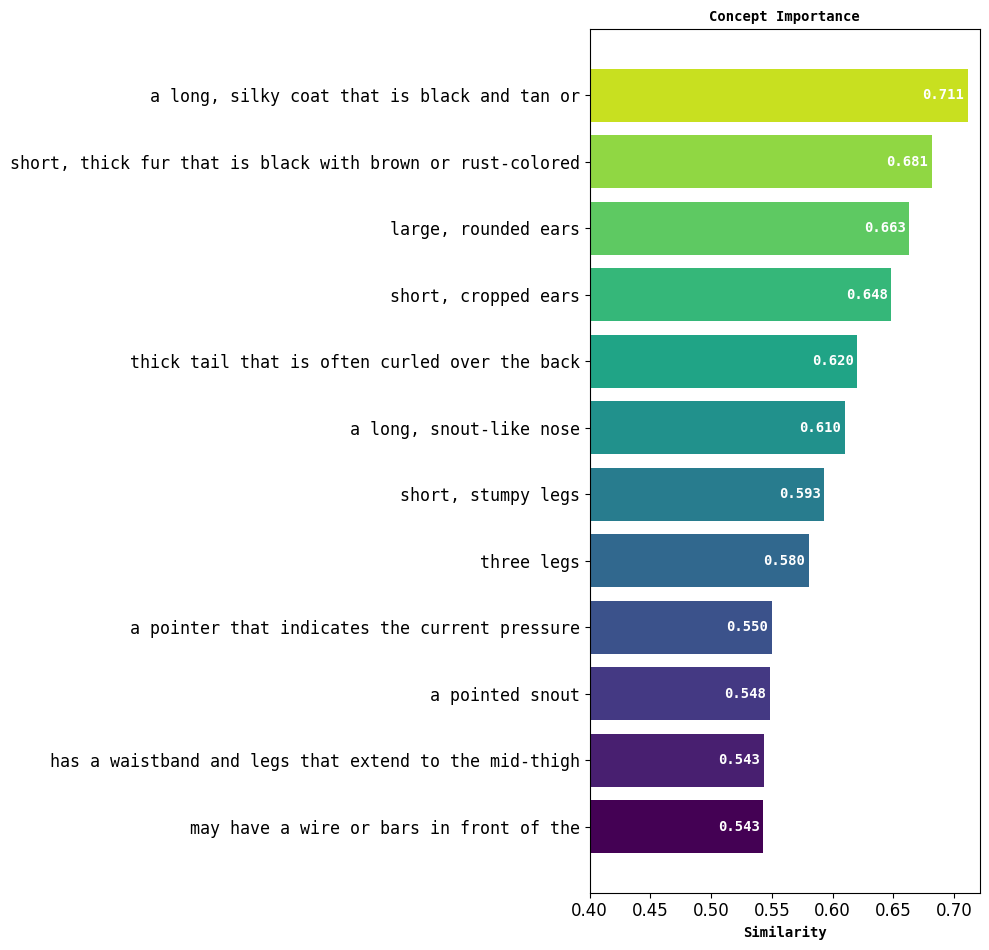

In [16]:
# score relevance plot
plt.figure(figsize=(10, len(pred_filtered) * 0.8))

colormap = plt.colormaps['viridis']  # Get a colormap
num_colors = len(pred_filtered)  # Number of colors needed
colors = [colormap(i / num_colors) for i in range(num_colors)]  # List of colors from the colormap

bars = plt.barh(range(len(pred_filtered)), scores_filtered[::-1], color=colors, height=0.8)  # Using barh for horizontal bars
texts_cut_plot = [' '.join(pf.split()[:10]) for pf in pred_filtered]
plt.yticks(range(len(texts_cut_plot)), texts_cut_plot[::-1], fontname='monospace')
plt.xlabel('Similarity', fontsize=10, fontweight='bold', family = 'monospace')
plt.title('Concept Importance', fontsize=10, fontweight='bold', family = 'monospace')

for bar, score in zip(bars, scores_filtered[::-1]):
    plt.text(bar.get_width() - 0.02, bar.get_y() + bar.get_height() / 2, f'{score:.3f}',
             ha='center', va='center', color='white', fontsize=10, fontweight='bold', fontname='monospace')

plt.tick_params(axis='x', labelsize=12, labelcolor='black')
plt.tick_params(axis='y', labelsize=12, labelcolor='black')
plt.xlim(0.4, max(scores_filtered) + 0.01)  # Adjust the maximum value as needed

# Show plot
plt.tight_layout()
plt.show()

vitb16 AUC: 0.519


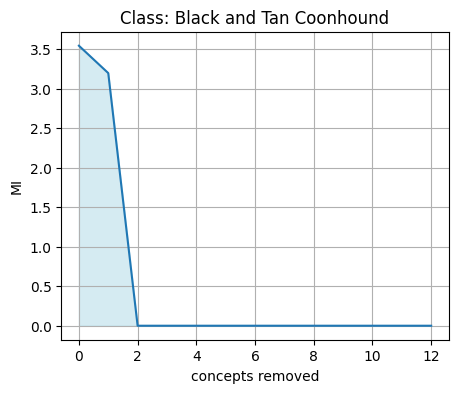

In [17]:
# average
fig, axs = plt.subplots(1,1, figsize = (5,4))
axs.set_xlabel('concepts removed')
axs.set_ylabel('MI')
axs.set_title('Class: {}'.format(imagenet_classes[folder2id[cls_folder]]))
axs.grid(True)

max_del_scores_len = max(len(deletion_scores_pca), len(deletion_scores_k))

deletion_scores_pca_padded = utils.pad_zeros(deletion_scores_pca, max_del_scores_len)
deletion_scores_k_padded = utils.pad_zeros(deletion_scores_k, max_del_scores_len)

deletion_scores = np.stack((deletion_scores_pca_padded, deletion_scores_k_padded)).mean(0)

auc = utils.get_statistics(deletion_scores)
x = list(range(len(deletion_scores)))
axs.plot(x, deletion_scores)
axs.fill_between(x, deletion_scores, color='lightblue', alpha=0.5)
print(classifier_folder, 'AUC: {:.3f}'.format(auc))

### Ven Diagram

In [30]:
img_name = cls_images[index].split('/')[-1]
w_texts, inter_texts = utils.circle_analysis(pred_filtered, all_descriptors, weight_dissection,
                                             folder2id[cls_folder], topk_w = 15)

print('class: {}'.format(imagenet_classes[folder2id[cls_folder]]))
print('class folder: {}, image name: {}\n'.format(cls_folder, img_name))
print('Total of {} Vision Concepts'.format(len(pred_filtered)))
print('Found {} Intersections\n'.format(len(inter_texts)))

class: Black and Tan Coonhound
class folder: n02089078, image name: ILSVRC2012_val_00005397.JPEG

Total of 12 Vision Concepts
Found 2 Intersections



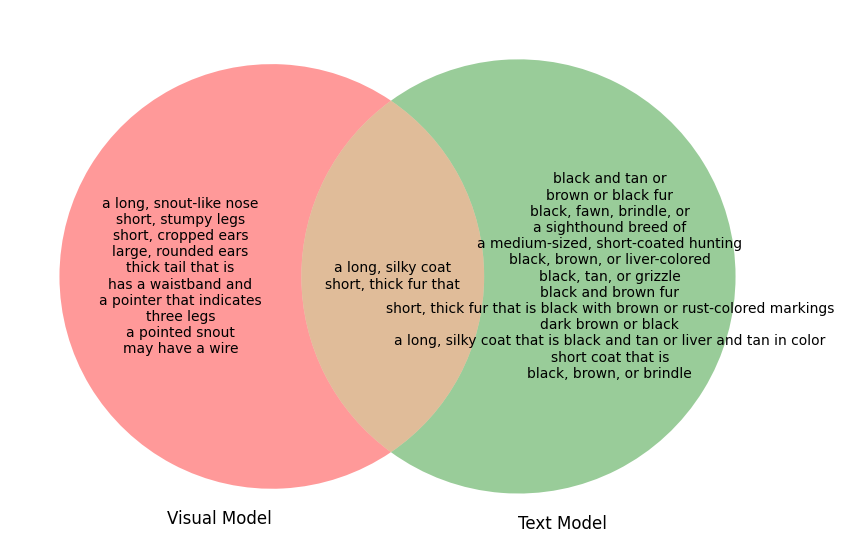

In [31]:
vc = [' '.join(p.split()[:4]) for p in pred_filtered]
wc_initial = [' '.join(p.split()[:4]) for p in w_texts]

wc1 = [c for c in inter_texts]
wc2 = [c for c in wc_initial if c not in wc1]
wc = wc1 + wc2[:20]

# Define the sets and their intersection
set_A = set(vc)
set_B = set(wc)
intersection = set_A.intersection(set_B)

fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
venn = venn2(subsets=(len(set_A - intersection) + 5, len(set_B - intersection) + 3, len(intersection) + 5),
             set_labels=('Visual Model', 'Text Model'), ax=ax)

# Add text inside the circles with smaller font size
venn.get_label_by_id('10').set_text('\n'.join(set_A - intersection))
venn.get_label_by_id('01').set_text('\n'.join(set_B - intersection))
venn.get_label_by_id('11').set_text('\n'.join(intersection))

# Show the plot
plt.show()